In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Synthetic dataset Gen


In [2]:
# Create blob synthetic dataset 
from sklearn.datasets import make_blobs

X,y = make_blobs(n_samples=5000, centers=[[1,5],[5,1],[0,0],[6,6]])
y = (y>1).astype(int)
x  = pd.DataFrame(X, columns=['x1','x2'])
y = pd.Series(y)

In [3]:
# chech the content of the set 
print('%d Data points and % d Features' % x.shape)
print('%d Positrive out of %d' % (y.sum(), y.shape[0]))

5000 Data points and  2 Features
2500 Positrive out of 5000


In [4]:
y_orig = y.copy

# mark some of the positive samples as unlabeled
hidden_size = 2000
y.loc[np.random.choice(y[y==1].index, size = hidden_size, replace=False)] = 0

In [5]:
# new label distribution
print('%d Positrive out of %d' % (y.sum(), y.shape[0]))

500 Positrive out of 5000


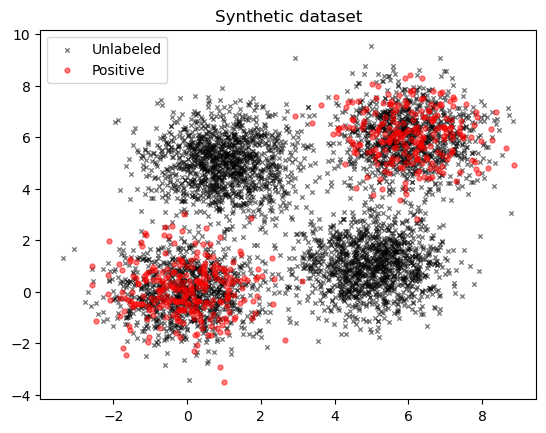

In [6]:
# plot the data
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c='k', marker='x', linewidth=1, s=10, alpha=0.5, label='Unlabeled')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='r', marker='.', linewidth=1, s=50, alpha=0.5, label='Positive')

plt.legend()
plt.title('Synthetic dataset')
plt.show()

# Standered Classifier Model


In [7]:
# Random forrest classifier model
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

rf.fit(x, y)

# store the scores assigned by this aproach 

result = pd.DataFrame({
    'truth' : y_orig,
    'lable' : y,
    'output_std' : rf.predict_proba(x)[:,1]
},columns=['truth','lable','output_std'])


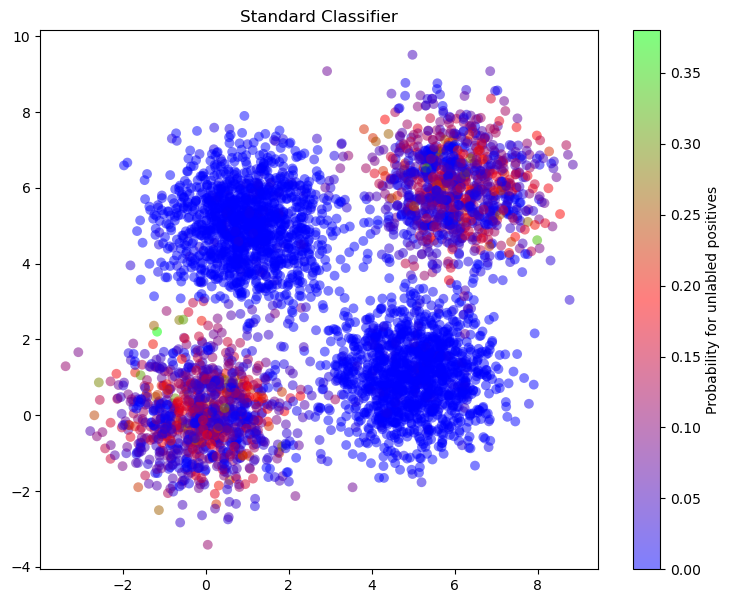

In [8]:
# visualize
plt.rcParams['figure.figsize'] = (9, 7)
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c= result[y == 0]['output_std'], linewidth=0, s=50, alpha=0.5, cmap='brg')

plt.colorbar(label ='Probability for unlabled positives')
plt.title('Standard Classifier')
plt.show()


# PU Bagging Model


- Create a training set by combining au positive data points With a random sample from the unlabeled points. With replacement.
- Build a classifier from this "bootstrap" sample. treating positive and unlabeled data points as positives and negatives. respectively,
- Apply the classifier to whatever the unlabeled data points were not included in the random sample - hereafter called OOB (Out of Bag) points — and record their scores.
- Repeat the three Steps above many times and finally assign to each point the average Of OOB scores it has received.


In [9]:
from sklearn.tree import DecisionTreeClassifier
estimator = DecisionTreeClassifier(random_state=42)

# indices of the positive and unlabeled datapoints
iP= y[y>0].index
iU = y[y<=0].index

# for each data point , keep track of how many times it has ben OOB and the sum of the probabilities assigned to it
num_oob = pd.DataFrame(np.zeros(y.shape), index = y.index)
sum_oob = pd.DataFrame(np.zeros(y.shape), index = y.index)

n_estimators = 10000
for i in range(n_estimators):
    # Get a bootstrap sample of unlabeled points for this round
    ib = np.random.choice(iU,replace= True , size= len(iP))
    
    i_oob = list(set(iU) - set(ib))
    
    # Get the tarining data (ALL positives and the boostrap sample of unlabeled) and train the estimator
    Xb = pd.concat([x[y>0], x.loc[ib]])
    yb = pd.concat([y[y>0], y.loc[ib]])
    estimator.fit(Xb, yb)
    
    # record OOB for this round 
    num_oob.loc[i_oob,0] += 1
    sum_oob.loc[i_oob , 0] += estimator.predict_proba(x.loc[i_oob])[:,1]
    
# finally store the probabilities assigned by this aproch 
result['output_bagging'] = sum_oob / num_oob

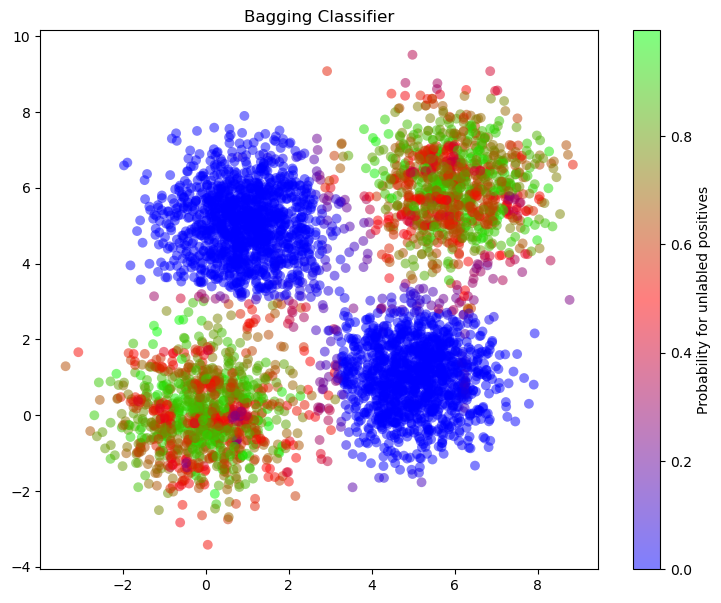

In [10]:
# visualize
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c= result[y == 0]['output_bagging'], linewidth=0, s=50, alpha=0.5, cmap='brg')
plt.colorbar(label ='Probability for unlabled positives')
plt.title('Bagging Classifier')
plt.show()